<a href="https://colab.research.google.com/github/WanPgui/Companies_sector_research/blob/main/companies_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn


In [3]:
!ls /content/drive/MyDrive/Mission_Capstone


Company_dataset.zip  extracted


In [4]:
# Load the dataset from ZIP → extract → read CSV
import pandas as pd
import zipfile
import os

# Correct paths (CASE-SENSITIVE)
BASE_DIR = "/content/drive/MyDrive/Mission_Capstone"
zip_path = f"{BASE_DIR}/Company_dataset.zip"
extract_path = f"{BASE_DIR}/extracted"

# Create extract directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# 1. Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 2. Find files inside the zip
files = os.listdir(extract_path)
print("Files inside zip:", files)

# 3. Detect the first data file
data_file = next(
    f for f in files if f.lower().endswith(('.csv', '.xlsx', '.tsv'))
)
full_path = os.path.join(extract_path, data_file)

# 4. Load and convert to CSV if necessary
if data_file.lower().endswith('.xlsx'):
    df = pd.read_excel(full_path)
    csv_path = f"{BASE_DIR}/company_dataset.csv"
    df.to_csv(csv_path, index=False)

elif data_file.lower().endswith('.tsv'):
    df = pd.read_csv(full_path, sep='\t')
    csv_path = f"{BASE_DIR}/company_dataset.csv"
    df.to_csv(csv_path, index=False)

else:
    # Already CSV
    csv_path = full_path
    df = pd.read_csv(csv_path)

print("Using dataset:", csv_path)

# 5. Preview data
df.head()


Files inside zip: ['companies_sorted.csv']
Using dataset: /content/drive/MyDrive/Mission_Capstone/extracted/companies_sorted.csv


,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


In [5]:
# Basic validation
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nDuplicates:", df.duplicated().sum())

df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB

Missing values:
Unnamed: 0                         0
name                               3
domain                       1650621
year founded                 3606980
industry                      290003
size range                         0
locality                     2508825
country                    

Index(['Unnamed: 0', 'name', 'domain', 'year founded', 'industry',
       'size range', 'locality', 'country', 'linkedin url',
       'current employee estimate', 'total employee estimate'],
      dtype='object')

In [6]:
# ===== DATA CLEANING & MISSING VALUE HANDLING =====

from datetime import datetime
import re
import pandas as pd

# 1. Drop useless column
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 2. Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

# 3. Create company age
current_year = datetime.now().year
df['company_age'] = current_year - df['year_founded']

# Remove unrealistic ages
df.loc[(df['company_age'] < 0) | (df['company_age'] > 200), 'company_age'] = None

# 4. Handle categorical missing values
df['industry'] = df['industry'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['locality'] = df['locality'].fillna('Unknown')

# 5. Convert size range to numeric average
def extract_avg_size(text):
    try:
        nums = re.findall(r'\d+', str(text))
        nums = [int(n) for n in nums]
        return sum(nums) / len(nums)
    except:
        return None

df['avg_size'] = df['size_range'].apply(extract_avg_size)

# 6. Fill numeric missing values with median
df['company_age'] = df['company_age'].fillna(df['company_age'].median())
df['avg_size'] = df['avg_size'].fillna(df['avg_size'].median())

# 7. Drop columns not needed for ML
df_clean = df[[
    'industry',
    'country',
    'company_age',
    'avg_size',
    'current_employee_estimate',
    'total_employee_estimate'
]]

# 8. Final check
print("Cleaned dataset shape:", df_clean.shape)
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

df_clean.head()


Cleaned dataset shape: (7173426, 6)

Missing values after cleaning:
industry                     0
country                      0
company_age                  0
avg_size                     0
current_employee_estimate    0
total_employee_estimate      0
dtype: int64


,industry,country,company_age,avg_size,current_employee_estimate,total_employee_estimate
0,information technology and services,united states,115.0,10001.0,274047,716906
1,information technology and services,india,58.0,10001.0,190771,341369
2,information technology and services,ireland,37.0,10001.0,190689,455768
3,military,united states,17.0,10001.0,162163,445958
4,accounting,united kingdom,37.0,10001.0,158363,428960


In [7]:
# Encoding and Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Copy
X = df_clean.copy()

# Encode categorical variables
le_industry = LabelEncoder()
le_country = LabelEncoder()

X['industry_enc'] = le_industry.fit_transform(X['industry'])
X['country_enc'] = le_country.fit_transform(X['country'])

# Select final numeric features
X_final = X[[
    'industry_enc',
    'country_enc',
    'company_age',
    'avg_size',
    'current_employee_estimate',
    'total_employee_estimate'
]]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

print("Ready for clustering:", X_scaled.shape)


Ready for clustering: (7173426, 6)


In [8]:
# Find Optimal K
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import random

# Take sample for finding K
sample_idx = random.sample(range(X_scaled.shape[0]), 200000)
X_sample = X_scaled[sample_idx]

scores = []

for k in [4, 5, 6, 7, 8, 9, 10]:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
    labels = kmeans.fit_predict(X_sample)

    score = silhouette_score(X_sample, labels)
    scores.append((k, score))
    print("K =", k, "Silhouette =", score)


K = 4 Silhouette = 0.3760075507284825
K = 5 Silhouette = 0.40322598091794876
K = 6 Silhouette = 0.4140431220885111
K = 7 Silhouette = 0.37566154442486493
K = 8 Silhouette = 0.3937654825856006
K = 9 Silhouette = 0.36370153721715776
K = 10 Silhouette = 0.3653362400793422


In [9]:
# Final clustering on full data
# Use best K from above
BEST_K = 6

kmeans = MiniBatchKMeans(
    n_clusters=BEST_K,
    batch_size=20000,
    random_state=42
)

df_clean['cluster'] = kmeans.fit_predict(X_scaled)

df_clean.head()


/tmp/ipython-input-1862698662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cluster'] = kmeans.fit_predict(X_scaled)


,industry,country,company_age,avg_size,current_employee_estimate,total_employee_estimate,cluster
0,information technology and services,united states,115.0,10001.0,274047,716906,4
1,information technology and services,india,58.0,10001.0,190771,341369,4
2,information technology and services,ireland,37.0,10001.0,190689,455768,4
3,military,united states,17.0,10001.0,162163,445958,4
4,accounting,united kingdom,37.0,10001.0,158363,428960,4


In [10]:
import joblib

# assuming your model variable is called kmeans
joblib.dump(kmeans, "kmeans_cluster_model.pkl")

print("KMeans model saved successfully")


KMeans model saved successfully


In [11]:
from google.colab import files
files.download("kmeans_cluster_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
df.to_csv("clustered_dataset.csv", index=False)

from google.colab import files
files.download("clustered_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import joblib
kmeans = joblib.load("/content/kmeans_cluster_model.pkl")

df['cluster'] = kmeans.predict(X_scaled)


In [16]:
# Create target variables based on your actual columns

# 1. Growth amount
df['growth'] = df['total_employee_estimate'] - df['current_employee_estimate']

# 2. Growth rate
df['growth_rate'] = df['growth'] / df['current_employee_estimate']

# 3. Create classification target
threshold_upper = 0.20
threshold_lower = -0.10

def assign_growth_category(rate):
    if rate > threshold_upper:
        return "Growing"
    elif rate < threshold_lower:
        return "Declining"
    else:
        return "Stable"

df['growth_category'] = df['growth_rate'].apply(assign_growth_category)

print(df[['industry','country','growth','growth_rate','growth_category']].head())


                              industry         country  growth  growth_rate  \
0  information technology and services   united states  442859     1.615997   
1  information technology and services           india  150598     0.789418   
2  information technology and services         ireland  265079     1.390112   
3                             military   united states  283795     1.750060   
4                           accounting  united kingdom  270597     1.708714   

  growth_category  
0         Growing  
1         Growing  
2         Growing  
3         Growing  
4         Growing  


In [17]:
# Understand clusters
# Add the 'cluster' column to the main df DataFrame
df['cluster'] = kmeans.predict(X_scaled)

cluster_profile = df.groupby('cluster').agg(
    companies=('cluster','count'),
    mean_company_age=('company_age','mean'),
    mean_current_emp=('current_employee_estimate','mean'),
    mean_total_emp=('total_employee_estimate','mean'),
    mean_growth=('growth','mean'),
    mean_growth_rate=('growth_rate','mean')
)

print(cluster_profile)


         companies  mean_company_age  mean_current_emp  mean_total_emp  \
cluster                                                                  
0          1789258         19.267518          6.387397       15.701743   
1          1629721         18.191775          5.145907       11.725706   
2          1946237         18.023102          5.210285       12.215778   
3          1627716         19.714372          6.327703       14.788407   
4           180494         89.783998        328.259388      755.283838   

         mean_growth  mean_growth_rate  
cluster                                 
0           9.314345               inf  
1           6.579799               inf  
2           7.005493               inf  
3           8.460704               inf  
4         427.024450               inf  


In [18]:
# Check growth distribution
cluster_growth = df.groupby(['cluster','growth_category']).size().unstack(fill_value=0)

cluster_growth_percent = cluster_growth.div(cluster_growth.sum(axis=1), axis=0) * 100

print(cluster_growth_percent)


growth_category    Growing     Stable
cluster                              
0                66.763206  33.236794
1                63.270707  36.729293
2                58.513531  41.486469
3                68.263198  31.736802
4                88.180771  11.819229


   current_employee_estimate  total_employee_estimate  growth  growth_rate  \
0                     274047                   716906  442859     1.615997   
1                     190771                   341369  150598     0.789418   
2                     190689                   455768  265079     1.390112   
3                     162163                   445958  283795     1.750060   
4                     158363                   428960  270597     1.708714   

  growth_category  
0         Growing  
1         Growing  
2         Growing  
3         Growing  
4         Growing  

Cluster Summary:
         total_companies  avg_current_employee  avg_total_employee  \
cluster                                                              
2                1946237              5.210285           12.215778   
0                1789258              6.387397           15.701743   
1                1629721              5.145907           11.725706   
3                1627716              6.327

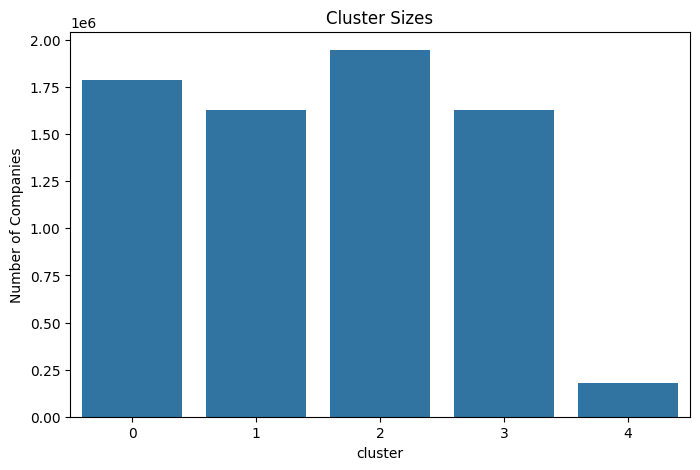

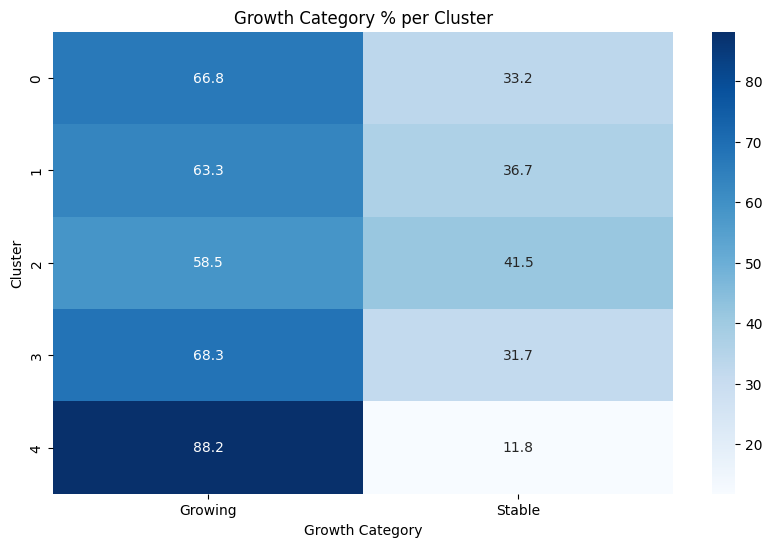

In [19]:
# 1. Compute Growth and Growth Category
# Growth = total_employee_estimate - current_employee_estimate
df['growth'] = df['total_employee_estimate'] - df['current_employee_estimate']

# Optional: growth rate
df['growth_rate'] = df['growth'] / df['current_employee_estimate']

# Define thresholds for growth categories
threshold_upper = 0.20   # 20% growth
threshold_lower = -0.10  # 10% shrink

def growth_category(row):
    if row['growth_rate'] > threshold_upper:
        return 'Growing'
    elif row['growth_rate'] < threshold_lower:
        return 'Declining'
    else:
        return 'Stable'

df['growth_category'] = df.apply(growth_category, axis=1)

# Quick check
print(df[['current_employee_estimate','total_employee_estimate','growth','growth_rate','growth_category']].head())

# 2. Summarize Clusters Efficiently
cluster_summary = df.groupby('cluster').agg(
    total_companies=('cluster', 'count'),
    avg_current_employee=('current_employee_estimate', 'mean'),
    avg_total_employee=('total_employee_estimate', 'mean'),
    avg_growth=('growth', 'mean'),
    avg_growth_rate=('growth_rate', 'mean')
).sort_values(by='total_companies', ascending=False)

print("\nCluster Summary:")
print(cluster_summary)

# 3. Growth Category Distribution per Cluster
growth_dist = df.groupby(['cluster','growth_category']).size().unstack(fill_value=0)

# Convert counts to percentages for easier understanding
growth_dist_pct = growth_dist.div(growth_dist.sum(axis=1), axis=0) * 100

print("\nGrowth Category % per Cluster:")
print(growth_dist_pct)

# 4. Optional: Visualizations (aggregated, memory-friendly)
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster size bar plot
plt.figure(figsize=(8,5))
sns.barplot(x=cluster_summary.index, y=cluster_summary['total_companies'])
plt.title("Cluster Sizes")
plt.ylabel("Number of Companies")
plt.show()

# Growth category distribution heatmap
plt.figure(figsize=(10,6))
sns.heatmap(growth_dist_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Growth Category % per Cluster")
plt.ylabel("Cluster")
plt.xlabel("Growth Category")
plt.show()


In [20]:
# Create growth measures
df['growth'] = df['total_employee_estimate'] - df['current_employee_estimate']
df['growth_rate'] = df['growth'] / df['current_employee_estimate']

# Softer thresholds to allow Declining class
threshold_upper = 0.15
threshold_lower = -0.05

def new_growth_category(rate):
    if rate > threshold_upper:
        return "Growing"
    elif rate < threshold_lower:
        return "Declining"
    else:
        return "Stable"

df['growth_category'] = df['growth_rate'].apply(new_growth_category)

print(df['growth_category'].value_counts())


growth_category
Growing    4701367
Stable     2472059
Name: count, dtype: int64


In [21]:
print(df['growth_rate'].min())
print(df['growth_rate'].quantile([0.05, 0.10, 0.25]))


0.0
0.05    0.0
0.10    0.0
0.25    0.0
Name: growth_rate, dtype: float64


In [22]:
# CREATE GROWTH MEASURES AND TARGET VARIABLES

df['growth'] = df['total_employee_estimate'] - df['current_employee_estimate']
df['growth_rate'] = df['growth'] / df['current_employee_estimate']

high_threshold = df['growth'].quantile(0.70)

def growth_level(val):
    if val >= high_threshold:
        return "High_Growth"
    else:
        return "Moderate_Growth"

df['growth_level'] = df['growth'].apply(growth_level)

print(df['growth_level'].value_counts())


growth_level
Moderate_Growth    4875980
High_Growth        2297446
Name: count, dtype: int64


In [ ]:
# FEATURE ENGINEERING AND ENCODING

df_model = df.copy()

df_model = pd.get_dummies(df_model, columns=['industry','country','cluster'])

X = df_model.drop(['growth','growth_rate','growth_category','growth_level'], axis=1)

y_class = df_model['growth_category']
y_level = df_model['growth_level']
y_reg = df_model['growth']


In [ ]:
# TRAIN TEST SPLITS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
le2 = LabelEncoder()

y_class_enc = le1.fit_transform(y_class)
y_level_enc = le2.fit_transform(y_level)

X_train, X_test, yc_train, yc_test = train_test_split(
    X, y_class_enc, test_size=0.2, random_state=42, stratify=y_class_enc
)

X_train2, X_test2, yl_train, yl_test = train_test_split(
    X, y_level_enc, test_size=0.2, random_state=42, stratify=y_level_enc
)

X_train3, X_test3, yr_train, yr_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)


In [ ]:
# BINARY CLASSIFICATION GROWING VS STABLE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

rf = RandomForestClassifier(n_estimators=120, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, yc_train)

pred = rf.predict(X_test)

print("Accuracy")
print(accuracy_score(yc_test, pred))

print("F1 Score")
print(f1_score(yc_test, pred, average='weighted'))

print(classification_report(yc_test, pred, target_names=le1.classes_))


In [ ]:
# CONFUSION MATRIX HEATMAP

cm = confusion_matrix(yc_test, pred)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix Growing vs Stable")
plt.colorbar()
plt.show()


In [ ]:
# HIGH GROWTH VS MODERATE GROWTH MODEL

rf2 = RandomForestClassifier(n_estimators=120, class_weight='balanced')
rf2.fit(X_train2, yl_train)

pred2 = rf2.predict(X_test2)

print("Accuracy Level Model")
print(accuracy_score(yl_test, pred2))

print("F1 Level Model")
print(f1_score(yl_test, pred2, average='weighted'))

print(classification_report(yl_test, pred2, target_names=le2.classes_))


In [ ]:
# REGRESSION ON GROWTH AMOUNT

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rfr = RandomForestRegressor(n_estimators=120, n_jobs=-1)
rfr.fit(X_train3, yr_train)

predr = rfr.predict(X_test3)

print("RMSE")
print(mean_squared_error(yr_test, predr, squared=False))

print("MAE")
print(mean_absolute_error(yr_test, predr))

print("R2")
print(r2_score(yr_test, predr))


In [ ]:
# ACTUAL VS PREDICTED PLOT

plt.figure(figsize=(7,6))
plt.scatter(yr_test[:2000], predr[:2000])
plt.title("Actual vs Predicted Growth")
plt.show()


In [ ]:
# FEATURE IMPORTANCE

imp = rf.feature_importances_
idx = np.argsort(imp)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(idx)), imp[idx])
plt.yticks(range(len(idx)), X.columns[idx])
plt.title("Important Features")
plt.show()
